In [1]:
import sys
sys.path.append("../") 

In [2]:
import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [4]:
num_gpus = 1
model_ctx = mx.gpu()

num_workers = 8
batch_size = 64 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
for X,y in train_data:
    print(X.shape)
    print(y.shape)
    break

(64, 1, 28, 28)
(64,)


### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(28,28)
out_units=10

In [7]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.001,ctx=model_ctx)

In [8]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [18]:
par,loss=inference.fit(epochs=100,batch_size=batch_size,data_loader=train_data,verbose=True)

  1%|          | 1/100 [00:14<24:05, 14.60s/it]

loss: 1.0498


 11%|█         | 11/100 [01:41<12:55,  8.71s/it]

loss: 0.4135


 21%|██        | 21/100 [03:16<12:37,  9.58s/it]

loss: 0.3813


 31%|███       | 31/100 [04:56<11:12,  9.75s/it]

loss: 0.3667


 41%|████      | 41/100 [06:27<08:52,  9.03s/it]

loss: 0.3576


 51%|█████     | 51/100 [07:54<07:00,  8.58s/it]

loss: 0.3514


 61%|██████    | 61/100 [09:23<05:41,  8.76s/it]

loss: 0.3467


 71%|███████   | 71/100 [10:52<04:15,  8.81s/it]

loss: 0.3428


 81%|████████  | 81/100 [12:26<02:50,  8.97s/it]

loss: 0.3400


 91%|█████████ | 91/100 [14:00<01:28,  9.83s/it]

loss: 0.3373


100%|██████████| 100/100 [15:26<00:00,  9.27s/it]


In [19]:
model.net.collect_params()

{'1.weight': Parameter (shape=(10, 784), dtype=float32),
 '1.bias': Parameter (shape=(10,), dtype=float32)}

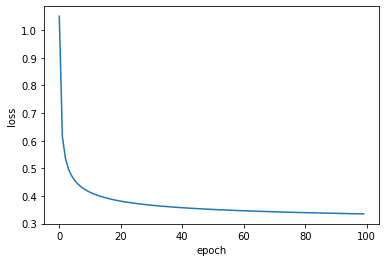

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")


fig=plt.figure(figsize=[5,5])
plt.plot(loss,color='blue',lw=3)
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.title('SGD Softmax MNIST', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()
plt.savefig('sgd_softmax.pdf', bbox_inches='tight')

In [22]:
model.net.save_parameters('softmax_sgd_100_epochs.params')

In [9]:
model.net.load_parameters('softmax_sgd_100_epochs.params',ctx=model_ctx)
par=dict()
for name,gluon_par in model.net.collect_params().items():
    par.update({name:gluon_par.data()})
               

In [10]:
total_samples,total_labels=inference.predict(par,batch_size=batch_size,num_samples=10,data_loader=val_data)

In [11]:
y_hat=np.quantile(total_samples,.5,axis=0)

In [12]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       979
           1       0.97      0.97      0.97      1133
           2       0.92      0.88      0.90      1030
           3       0.90      0.89      0.89      1008
           4       0.88      0.91      0.90       980
           5       0.84      0.85      0.84       890
           6       0.88      0.94      0.91       956
           7       0.91      0.92      0.91      1027
           8       0.85      0.84      0.85       973
           9       0.93      0.85      0.89      1008

    accuracy                           0.90      9984
   macro avg       0.90      0.90      0.90      9984
weighted avg       0.90      0.90      0.90      9984



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [13]:
from hamiltonian.inference.sgld import sgld

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.01,ctx=model_ctx)

In [11]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

modules re-loaded


In [15]:
loss,posterior_samples=inference.sample(epochs=100,batch_size=batch_size,
                             data_loader=train_data,
                             verbose=True)

  1%|          | 1/100 [00:12<21:05, 12.79s/it]

loss: 0.8712


 11%|█         | 11/100 [01:43<13:21,  9.00s/it]

loss: 0.6071


 21%|██        | 21/100 [03:09<11:13,  8.52s/it]

loss: 0.5668


 31%|███       | 31/100 [04:36<10:00,  8.70s/it]

loss: 0.5443


 41%|████      | 41/100 [06:08<09:14,  9.40s/it]

loss: 0.5319


 51%|█████     | 51/100 [07:41<07:35,  9.30s/it]

loss: 0.5197


 61%|██████    | 61/100 [09:09<05:36,  8.64s/it]

loss: 0.5014


 71%|███████   | 71/100 [10:37<04:14,  8.76s/it]

loss: 0.4925


 81%|████████  | 81/100 [12:06<02:47,  8.82s/it]

loss: 0.4839


 91%|█████████ | 91/100 [13:34<01:19,  8.81s/it]

loss: 0.4763


  1%|          | 1/100 [00:08<13:57,  8.46s/it]

loss: 0.6531


 11%|█         | 11/100 [01:37<13:19,  8.98s/it]

loss: 0.6566


 21%|██        | 21/100 [03:03<11:26,  8.69s/it]

loss: 0.6380


 31%|███       | 31/100 [04:27<09:51,  8.57s/it]

loss: 0.6107


 41%|████      | 41/100 [05:51<08:16,  8.41s/it]

loss: 0.5914


 51%|█████     | 51/100 [07:14<06:49,  8.35s/it]

loss: 0.5810


 61%|██████    | 61/100 [08:41<05:34,  8.59s/it]

loss: 0.5633


 71%|███████   | 71/100 [10:03<03:55,  8.12s/it]

loss: 0.5448


 81%|████████  | 81/100 [11:25<02:35,  8.16s/it]

loss: 0.5361


 91%|█████████ | 91/100 [12:51<01:18,  8.75s/it]

loss: 0.5301


100%|██████████| 100/100 [14:05<00:00,  8.45s/it]


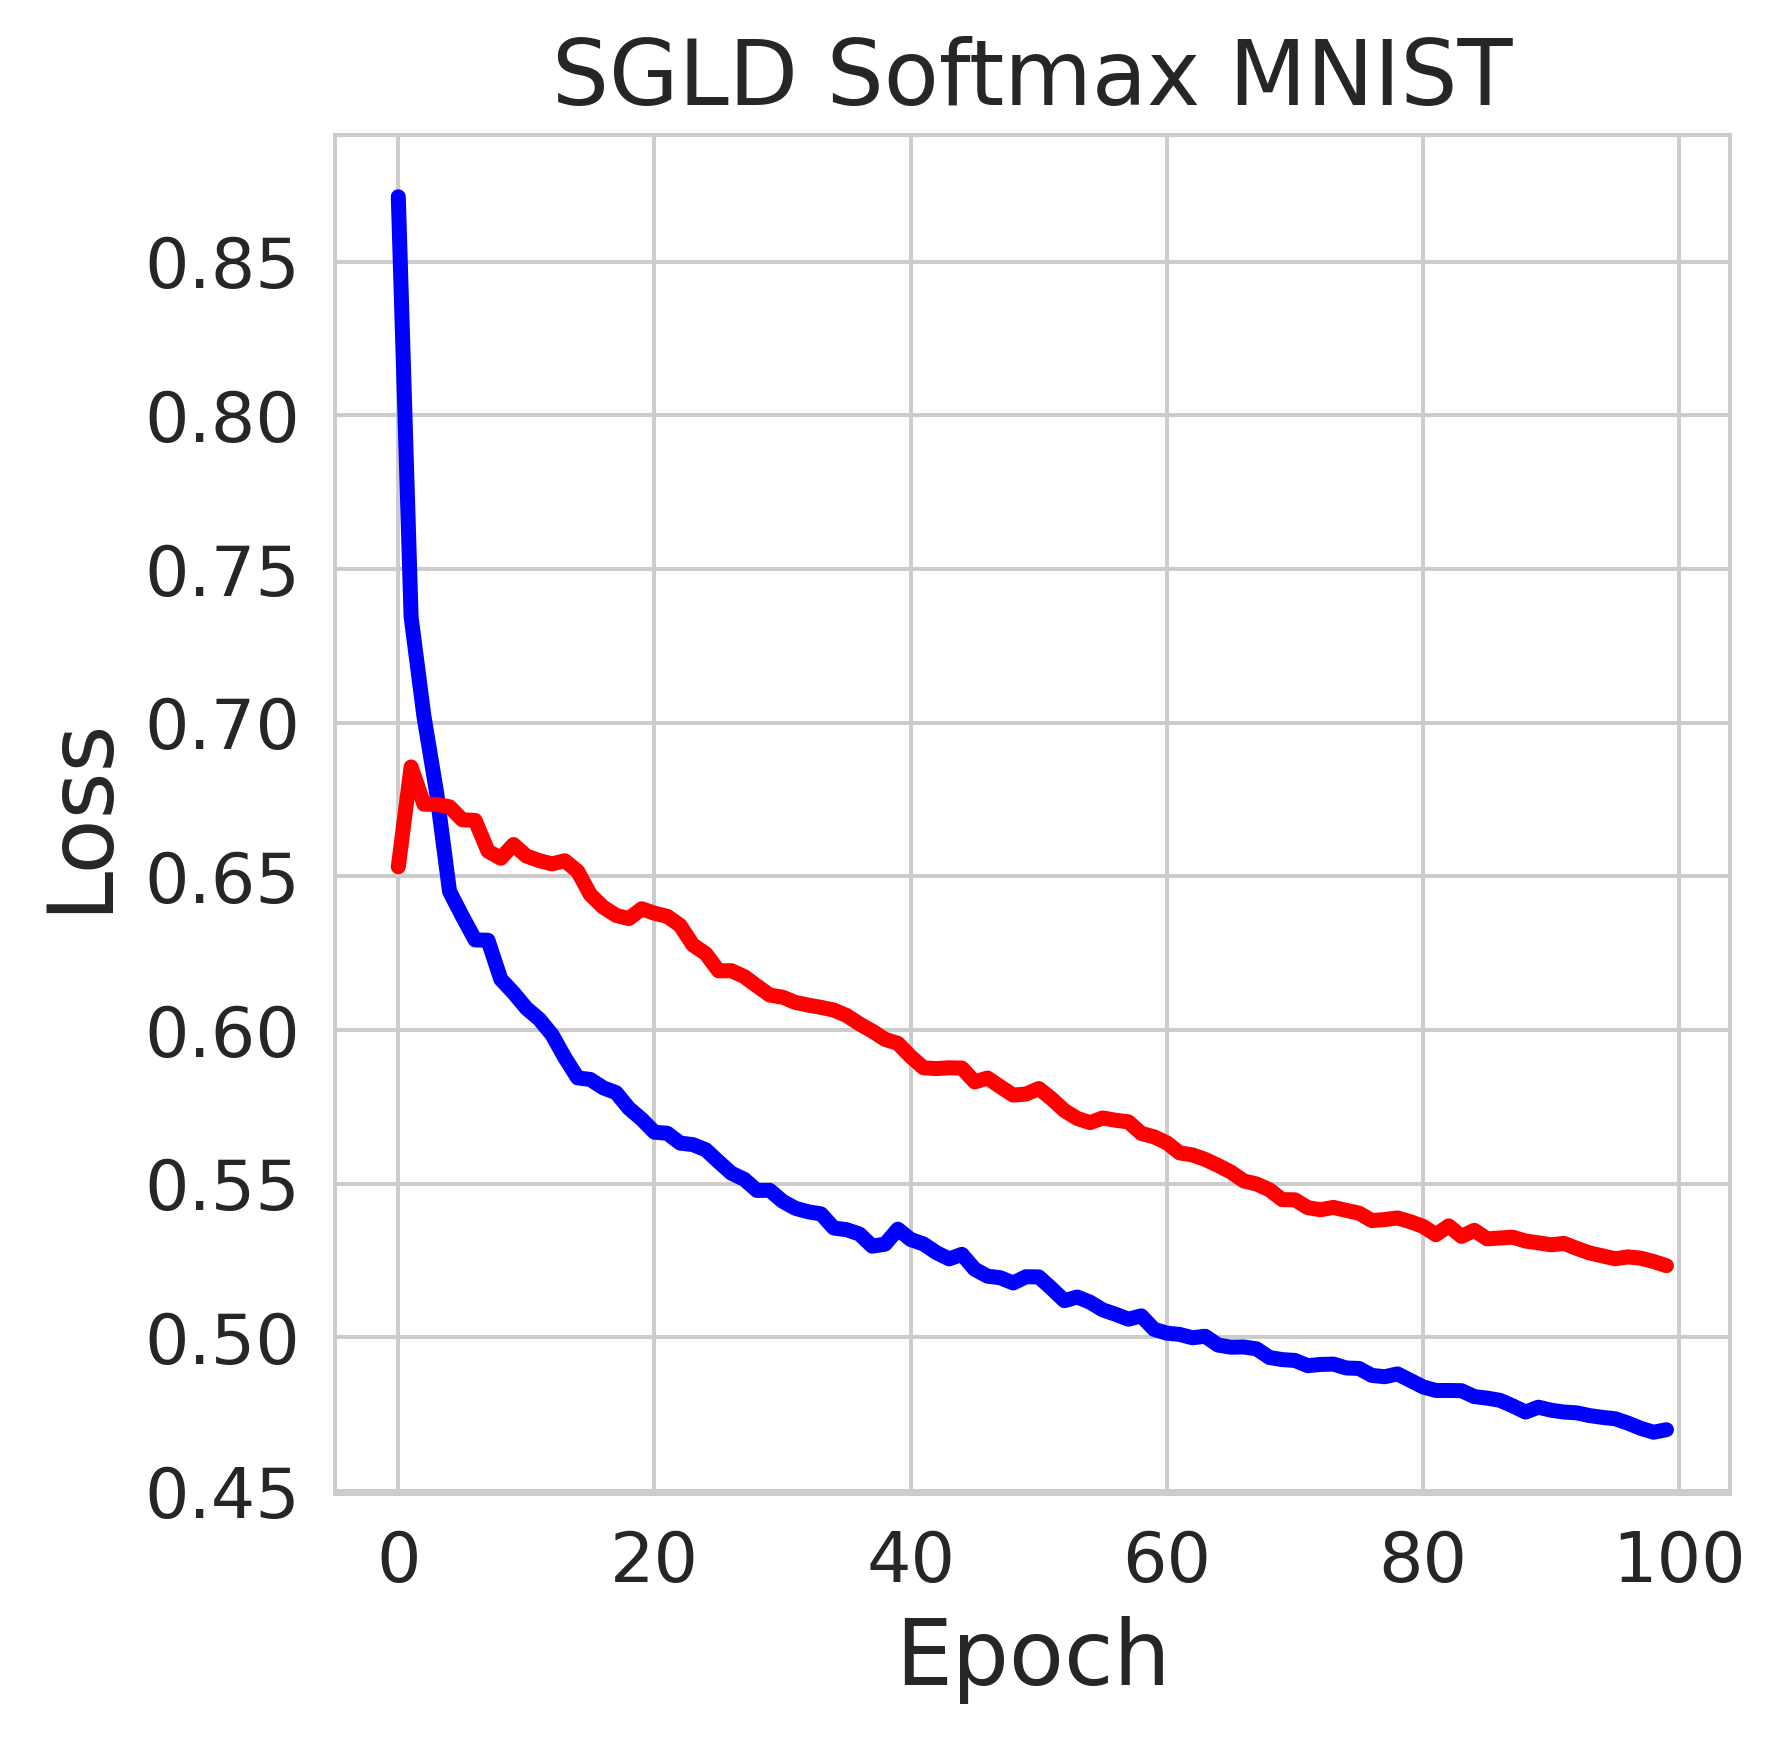

<Figure size 2160x1440 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")


fig=plt.figure(figsize=[5,5])
plt.plot(loss[0],color='blue',lw=3)
plt.plot(loss[1],color='red',lw=3)
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.title('SGLD Softmax MNIST', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.savefig('sgld_softmax.pdf', bbox_inches='tight')

In [17]:
posterior_samples_flat=[item for sublist in posterior_samples for item in sublist]

In [18]:
total_samples,total_labels=inference.predict(posterior_samples_flat,5,data_loader=val_data)

In [19]:
from sklearn.metrics import classification_report
posterior_samples

y_hat=np.quantile(total_samples,.1,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       980
           1       0.91      0.99      0.95      1135
           2       0.84      0.91      0.87      1032
           3       0.79      0.90      0.84      1010
           4       0.80      0.96      0.87       982
           5       0.80      0.80      0.80       892
           6       0.95      0.87      0.91       958
           7       0.88      0.90      0.89      1028
           8       0.92      0.66      0.77       974
           9       0.98      0.70      0.82      1009

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [30]:
chains=len(posterior_samples)
posterior_samples_multiple_chains=list()
for i in range(chains):
    single_chain={var:list() for var in model.par}
    for file in posterior_samples[i]:
        model.net.load_parameters(file,ctx=model_ctx)
        for name,par in model.net.collect_params().items():
            single_chain[name].append(par.data().asnumpy())
    posterior_samples_single_chain={var:np.asarray(single_chain[var]) for var in single_chain}
    posterior_samples_multiple_chains.append(posterior_samples_single_chain)

In [ ]:
posterior_samples_multiple_chains=inference.posterior_diagnostics(posterior_samples)

In [35]:
import arviz as az

datasets=[az.convert_to_inference_data(sample) for sample in posterior_samples_multiple_chains]
dataset = az.concat(datasets, dim="chain")

In [36]:
az.summary(dataset)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1.weight[0],0.283,1.972,-3.544,4.470,0.033,0.027,2586.0,3328.0,1.08
1.weight[1],0.684,2.124,-2.830,4.596,0.050,0.036,1814.0,2467.0,1.07
1.weight[2],0.587,1.611,-3.519,3.235,0.032,0.023,2585.0,2465.0,0.98
1.weight[3],-0.601,1.473,-3.014,2.225,0.036,0.025,1862.0,2465.0,0.98
1.weight[4],1.081,1.873,-1.540,4.713,0.036,0.032,2587.0,2734.0,1.09
...,...,...,...,...,...,...,...,...,...
1.weight[780],0.096,1.432,-2.524,2.514,0.018,0.020,6602.0,2365.0,0.99
1.weight[781],-0.877,2.193,-4.712,2.920,0.058,0.041,1462.0,1790.0,1.07
1.weight[782],-0.155,2.253,-5.070,3.895,0.037,0.036,3504.0,2619.0,1.19
1.weight[783],-0.721,2.104,-4.550,2.892,0.029,0.028,6551.0,2491.0,1.07


In [44]:
mean_r_hat_values={var:float(az.rhat(dataset)[var].mean().data) for var in model.par}

In [52]:
print(mean_r_hat_values)

{'1.weight': 1.0340801293013426, '1.bias': 1.0001861857932042}


In [47]:
mean_ess_values={var:float(az.ess(dataset)[var].mean().data) for var in model.par}

In [48]:
mean_ess_values

{'1.weight': 4242.692772026483, '1.bias': 6602.059991327962}

In [49]:
mean_mcse_values={var:float(az.mcse(dataset)[var].mean().data) for var in model.par}

In [50]:
mean_mcse_values

{'1.weight': 0.028454770948850395, '1.bias': 0.022408065114994276}

# Hierarchical Softmax <a class="anchor" id="chapter3"></a>

In [12]:
from hamiltonian.models.softmax import hierarchical_softmax
from hamiltonian.inference.sgld import sgld

model=hierarchical_softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.01,ctx=model_ctx)

In [13]:
loss,posterior_samples=inference.sample(epochs=100,batch_size=batch_size,
                             data_loader=train_data,
                             verbose=True)

  1%|          | 1/100 [00:10<16:40, 10.11s/it]

loss: 1.2817


 11%|█         | 11/100 [01:53<15:10, 10.23s/it]

loss: 1.2268


 21%|██        | 21/100 [03:36<13:31, 10.27s/it]

loss: 0.9124


 31%|███       | 31/100 [05:19<11:56, 10.39s/it]

loss: 1.4511


 41%|████      | 41/100 [07:02<10:13, 10.40s/it]

loss: 1.0044


 51%|█████     | 51/100 [08:45<08:29, 10.39s/it]

loss: 0.9797


 61%|██████    | 61/100 [10:27<06:38, 10.23s/it]

loss: 1.0021


 71%|███████   | 71/100 [12:11<04:56, 10.22s/it]

loss: 0.8981


 81%|████████  | 81/100 [13:54<03:14, 10.25s/it]

loss: 0.9199


 91%|█████████ | 91/100 [15:38<01:33, 10.36s/it]

loss: 0.9076


  1%|          | 1/100 [00:09<16:24,  9.94s/it]

loss: 1.1196


 11%|█         | 11/100 [01:50<15:12, 10.25s/it]

loss: 1.1516


 21%|██        | 21/100 [03:30<13:10, 10.00s/it]

loss: 1.1714


 31%|███       | 31/100 [05:11<11:29,  9.99s/it]

loss: 1.1608


 41%|████      | 41/100 [06:52<09:50, 10.01s/it]

loss: 1.0880


 51%|█████     | 51/100 [08:32<08:09,  9.98s/it]

loss: 1.0440


 61%|██████    | 61/100 [10:13<06:36, 10.16s/it]

loss: 0.9967


 71%|███████   | 71/100 [11:54<04:52, 10.10s/it]

loss: 1.0032


 81%|████████  | 81/100 [13:35<03:15, 10.30s/it]

loss: 0.9588


 91%|█████████ | 91/100 [15:14<01:29,  9.98s/it]

loss: 2.5654


100%|██████████| 100/100 [16:45<00:00, 10.06s/it]


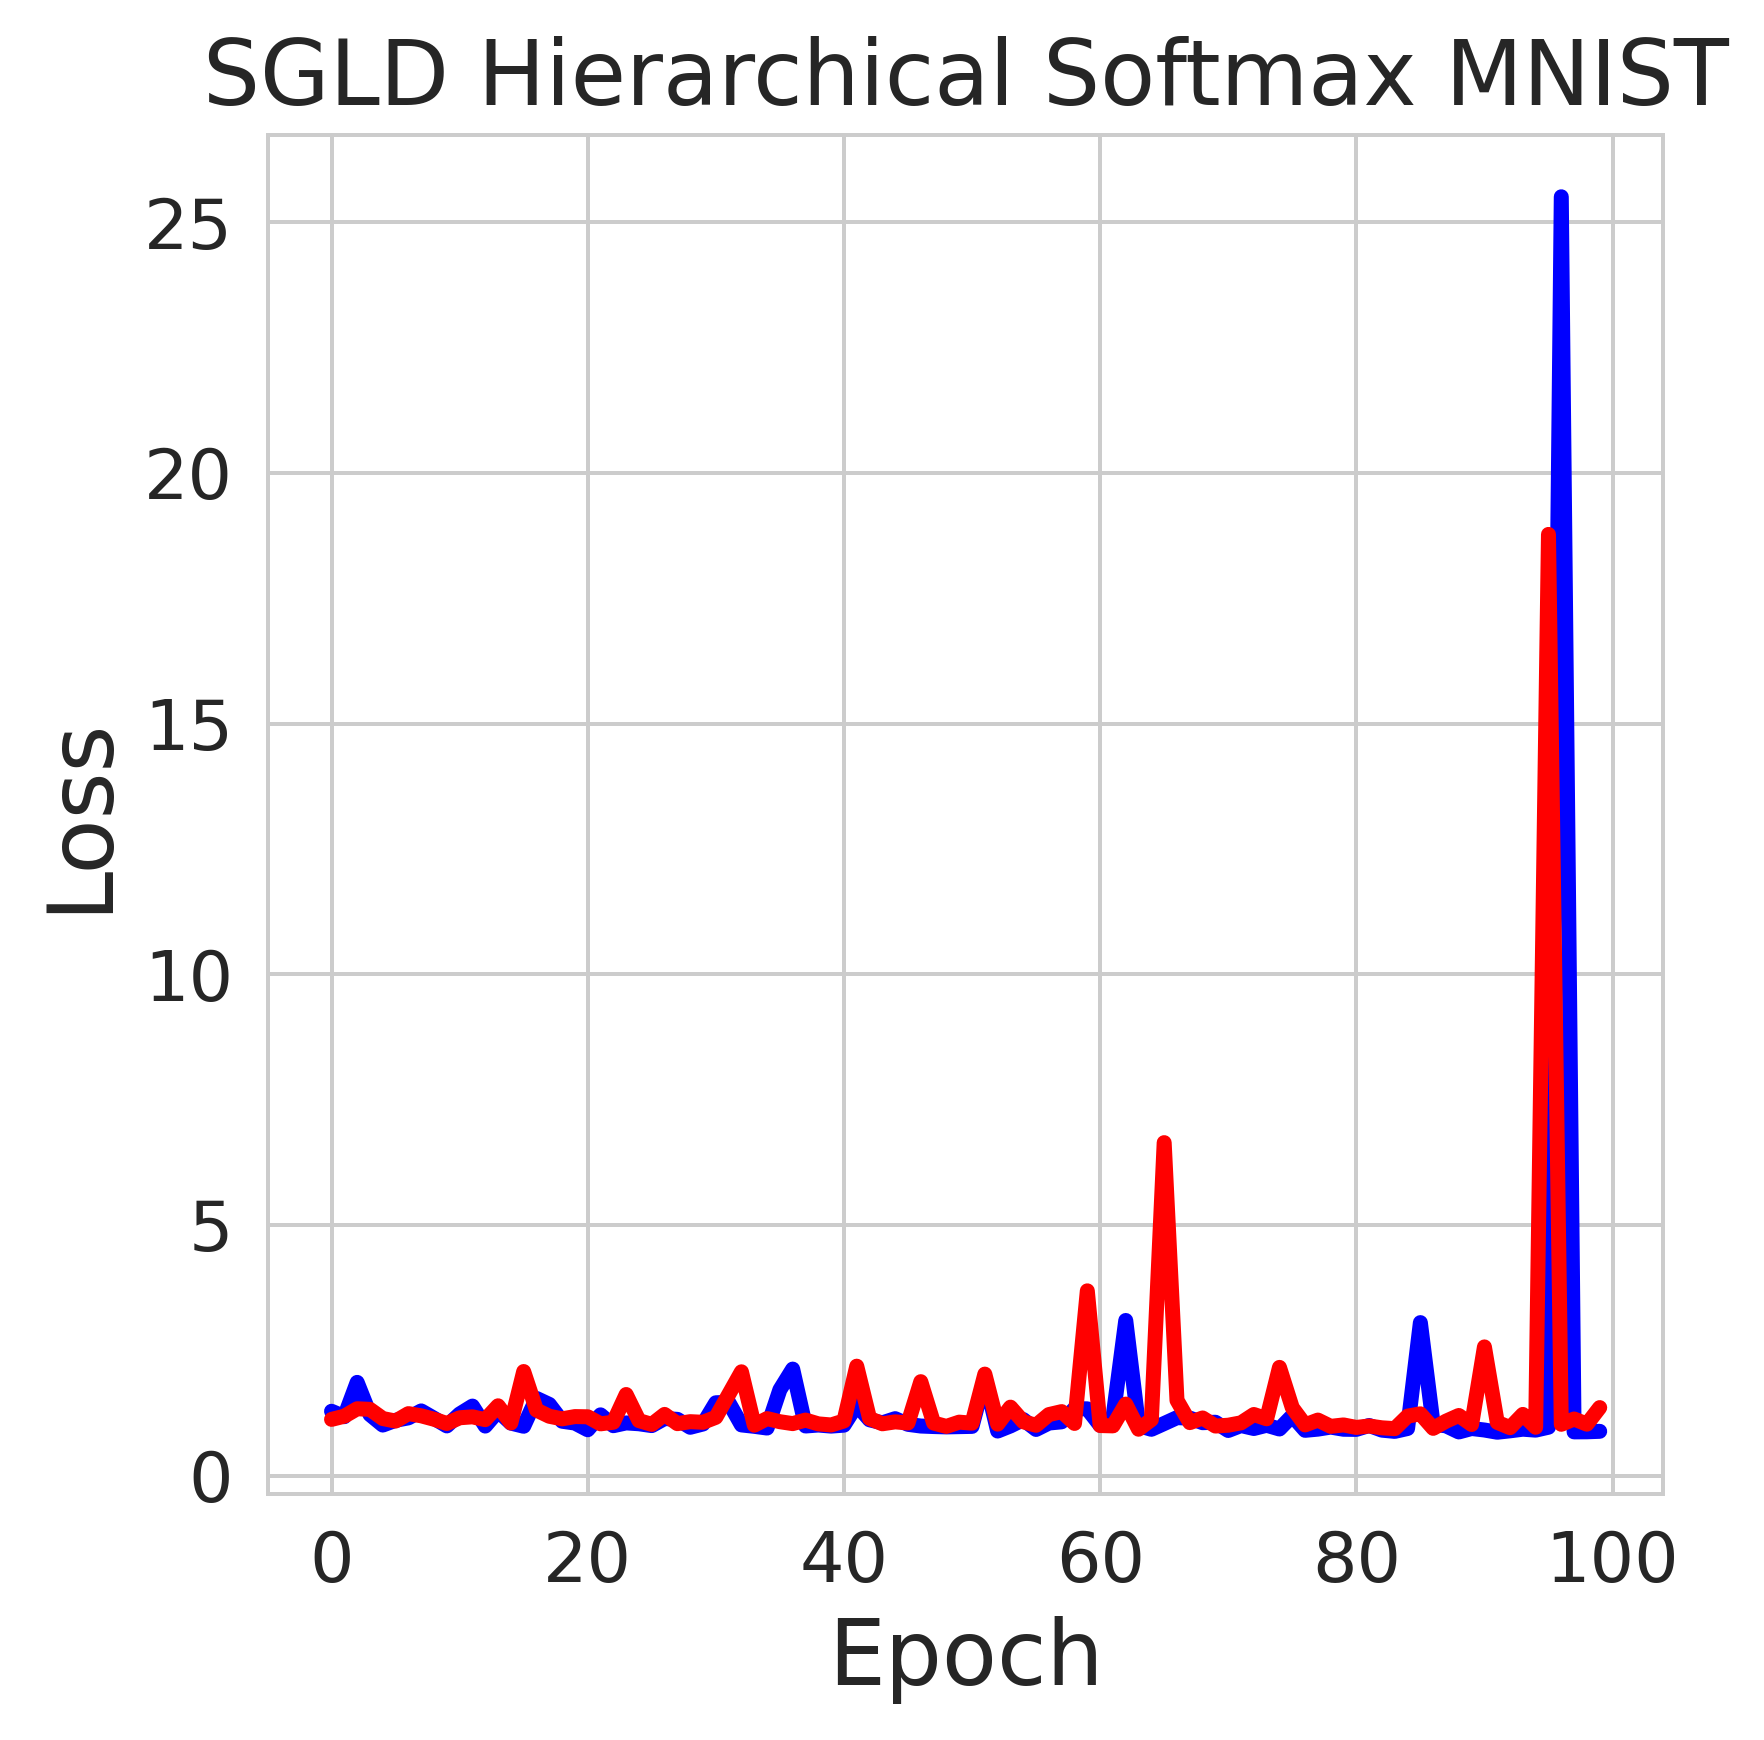

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")


fig=plt.figure(figsize=[5,5])
plt.plot(loss[0],color='blue',lw=3)
plt.plot(loss[1],color='red',lw=3)
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.title('SGLD Hierarchical Softmax MNIST', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.savefig('sgld_hierarchical_softmax.pdf', bbox_inches='tight')

In [15]:
posterior_samples_flat=[item for sublist in posterior_samples for item in sublist]
total_samples,total_labels=inference.predict(posterior_samples_flat,5,data_loader=val_data)

In [17]:
from sklearn.metrics import classification_report
posterior_samples

y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.97      0.97      1135
           2       0.92      0.89      0.90      1032
           3       0.87      0.90      0.89      1010
           4       0.92      0.92      0.92       982
           5       0.87      0.84      0.85       892
           6       0.92      0.94      0.93       958
           7       0.91      0.92      0.91      1028
           8       0.85      0.87      0.86       974
           9       0.92      0.89      0.90      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [18]:
posterior_samples_multiple_chains=inference.posterior_diagnostics(posterior_samples)

In [19]:
import arviz as az

datasets=[az.convert_to_inference_data(sample) for sample in posterior_samples_multiple_chains]
dataset = az.concat(datasets, dim="chain")

In [20]:
az.summary(dataset)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1.weight[0],0.140,1.830,-2.904,2.925,0.045,0.032,1863.0,2638.0,1.07
1.weight[1],-0.141,1.930,-2.751,4.151,0.040,0.029,2929.0,2079.0,1.06
1.weight[2],0.491,1.531,-2.373,3.256,0.026,0.018,3654.0,2465.0,0.96
1.weight[3],-0.149,1.789,-3.232,3.051,0.033,0.025,3284.0,2465.0,1.00
1.weight[4],1.223,1.724,-1.230,4.511,0.028,0.025,3516.0,2680.0,1.04
...,...,...,...,...,...,...,...,...,...
1.weight[780],-0.453,1.569,-3.225,2.787,0.020,0.021,6495.0,2996.0,1.02
1.weight[781],-0.702,1.866,-4.279,2.652,0.044,0.031,1697.0,2238.0,1.05
1.weight[782],0.147,2.194,-4.905,3.669,0.033,0.029,4151.0,2496.0,1.01
1.weight[783],-0.786,1.934,-3.943,2.865,0.035,0.027,3401.0,2558.0,1.01


In [21]:
mean_r_hat_values={var:float(az.rhat(dataset)[var].mean().data) for var in model.par}
print(mean_r_hat_values)

{'1.weight': 1.0343923485139621, '1.bias': 1.049039423174153}


In [22]:
mean_ess_values={var:float(az.ess(dataset)[var].mean().data) for var in model.par}
print(mean_ess_values)

{'1.weight': 4265.958540284429, '1.bias': 6602.059991327962}


In [24]:
mean_mcse_values={var:float(az.mcse(dataset)[var].mean().data) for var in model.par}
print(mean_mcse_values)

{'1.weight': 0.02742205088301462, '1.bias': 0.005080949031033575}
